# IBM Data Science Capstone Project - High-risk Hunger!

## 1. Introduction

Food: a vessel bridging the eternal conflict between starvation and survival. How many times have you been pondering which chicken shop to visit, when BANG you come face-to-face with life-threatening crime? Probably never. Regardless, you shouldn't have to worry about crime whilst you're gourging on your favourite cheap eats!

High-risk Hunger sees the much anticipated combination of restaurant ratings and regional crime figures, with moderate effect! Using Foursquare API, Gov.uk data and Folium choropleth maps, this notebook will show you where (or where not) to eat in the Lewisham and Southwark boroughs of London.

People often describe food as 'worth dying for' - I disagree.

## 2. Data

This project combines restaurant ratings with '*Lower Layer Super Output Area*' (LSOA) crime figures to create a folium choropleth map depicting borough-based crime and restaurant reviews. 

1. Restaurant location, name and ratings from [FourSquare API](https://developer.foursquare.com/)
2. Crime data from the [London Datastore](https://data.london.gov.uk/)
3. LSOA GeoJson boundaries from [Martinjc git-hub](https://raw.githubusercontent.com/martinjc/UK-GeoJSON/master/json/electoral/gb/wards.json)
4. LSOA population estimates from the [Office of National Statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimates)

## 3. Methodology

Data was loaded and cleansed using the Pandas package.

An evenly tempered crime scoring metric was used to indicate safety across different LSOAs. The distribution of crime scores was visualized in histograms using the Seaborn package. Scores were then transformed and scaled using PowerTransformer (Yeo-Johnson) and MinMax Scaler to reduce skew and create a score range between 0 - 1 respectively.

LSOA boundary coordinates were integrated using the JSON module and the choropleth map was visualized using Folium.

## 4. Results

In [22]:
#import modules for data acquisition and visualisation
import requests 
import pandas as pd
import numpy as np
import wget
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from IPython.display import HTML
from sklearn import preprocessing
print("Loaded Core Libraries!")

#import modules for geolocation and mapmaking
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from IPython.display import Image 
from IPython.core.display import HTML 
import descartes
from pandas.io.json import json_normalize
import folium
import branca.colormap as cm
print("Loaded Mapping Libraries!")

Loaded Core Libraries!
Loaded Mapping Libraries!


### 4.1 Restaurant data using the FourSquare API:

Assign our FourSquare API credentials:

In [2]:
#save credentials for foursquare API
CLIENT_ID = 'ELGTJYC3OYFDAKI5Z42XEOXYDCWEH2XYDA3GZFG42J34HXYF' # your Foursquare ID
CLIENT_SECRET = 'YK1GA4QY3XHXHATS5MHALWKFZCE0V1RHDVRYOMGDNIFQOM3T' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 1000

Request foursquare restaurant data within a 2.5m radius of a specified address:

In [3]:
#set address
address = '118 Rye Ln, Peckham, London' #address assigned to a local dive
geolocator = Nominatim(user_agent="foursquare_agent", timeout = 20) #assign foursquare agent to identify lng, lat
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#Get venues within 2.5M of assigned address
radius = 2500
search_query = 'Restaurant'

#define the corresponding URL
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

#request and examine results
results = requests.get(url).json()

Extract the values nested within response and query the restaurant ratings and venue data using FourSquare premium calls:

In [4]:
#extract venue data
venues = results['response']['venues']
dataframe = json_normalize(venues)

#keep only columns that include venue name, category, location and id
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
restaurant = dataframe.loc[:, filtered_columns]

#function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#filter the category for each row
restaurant['categories'] = restaurant.apply(get_category_type, axis=1)

#clean column names by keeping only last term
restaurant.columns = [column.split('.')[-1] for column in restaurant.columns]

#get restaurant names and ratings
venue_names = []
venue_ratings = []
for ind,row in dataframe.iterrows():
    venue_id = dataframe.loc[ind, 'id']
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    venue_names.append(result['response']['venue']['name'])
    try:
        venue_ratings.append(result['response']['venue']['rating'])
    except:
        venue_ratings.append(0)
        
#turn name and ratings lists into Pandas dataframe
ratings = pd.DataFrame(np.column_stack([venue_names, venue_ratings]), columns=['name','USERSCORE'])
ratings['USERSCORE'] = ratings['USERSCORE'].astype(float) #convert string into float
ratings = ratings.query("USERSCORE > 0") #remove any placeholder values

#merge ratings with location data and drop unnecessary columns
restaurant = pd.merge(ratings, restaurant, on= ['name'])
restaurant = restaurant[['name', 'USERSCORE', 'address','lat', 'lng', 'labeledLatLngs']]
restaurant.columns=['NAME', 'USERSCORE', 'ADDRESS','LAT','LNG','labeledLatLngs']

#format column headers
restaurant['ADDRESS'] = restaurant['ADDRESS'].str.title()
restaurant['NAME'] = restaurant['NAME'].str.title()
restaurant.head()

D:\DSProjects\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,NAME,USERSCORE,ADDRESS,LAT,LNG,labeledLatLngs
0,Franklins Restaurant,8.3,157 Lordship Ln,51.456066,-0.076048,"[{'label': 'display', 'lat': 51.45606610090473..."
1,Lovely House,6.7,119 Bellenden Road,51.467892,-0.072411,"[{'label': 'display', 'lat': 51.46789189338897..."
2,Pasha Central Asian Restaurant,6.2,158 Camberwell Rd,51.479494,-0.095399,"[{'label': 'display', 'lat': 51.4794944597583,..."
3,Hong Kong City,6.1,43 New Cross Rd,51.477575,-0.051205,"[{'label': 'display', 'lat': 51.47757480046282..."
4,Reyna,6.9,379 New Cross Rd,51.475963,-0.034306,"[{'label': 'display', 'lat': 51.47596302384182..."


### 4.2 Crime dataset for areas in london:

#### 4.2.1 Crime data

Download the London crime data and filter for values within Lewisham and Southwark:

In [5]:
#download relevant crime data
url = 'https://data.london.gov.uk/download/recorded_crime_summary/644a9e0d-75a3-4c3a-91ad-03d2a7cb8f8e/MPS%20LSOA%20Level%20Crime%20%28most%20recent%2024%20months%29.csv'
london_crime = wget.download(url)
london_crime = pd.read_csv(london_crime)

#filter df for relevant boroughs and create sum column
london_crime = london_crime.query('Borough == ["Lewisham", "Southwark"]')
london_crime['Sum'] = london_crime.iloc[:,4:28].sum(axis = 1)

#create table with LSOA codes and sum crime counts over two years
crime = london_crime[['LSOA Code', 'Borough','Major Category', 'Sum']]
crime = crime.groupby(['LSOA Code', 'Borough', 'Major Category']).sum().reset_index()
crime.columns = ['LSOA11CD', 'BOROUGH','CRIME','INCIDENCE']

#view data
crime.sort_values(by=['LSOA11CD', 'CRIME']).head()

,LSOA11CD,BOROUGH,CRIME,INCIDENCE
0,E01003189,Lewisham,Arson and Criminal Damage,40
1,E01003189,Lewisham,Burglary,23
2,E01003189,Lewisham,Drug Offences,32
3,E01003189,Lewisham,Miscellaneous Crimes Against Society,5
4,E01003189,Lewisham,Possession of Weapons,6


We now have a table which shows crime grouping sums by LSOA code for Lewisham and Peckham. Next we will calculate the number of crimes per resident to use a metric indicator for risk in each LSOA region.

#### 4.2.2 Population data and crime scores

Appending borough population sizes:

In [8]:
#get borough population numbers
lsoa_res = gpd.read_file(r"D:\DSProjects\Jupyter\IBM_capstone\london.json")
lsoa_res = lsoa_res[['LSOA11CD', 'USUALRES']] #drop useless columns
lsoa_res.columns = ['LSOA11CD', 'RESIDENTS']

#merge tables, drop irrelavent columns and rename columns
crime_join = pd.merge(crime, lsoa_res, on= ['LSOA11CD'])
crime_join.head()

,LSOA11CD,BOROUGH,CRIME,INCIDENCE,RESIDENTS
0,E01003189,Lewisham,Arson and Criminal Damage,40,1670
1,E01003189,Lewisham,Burglary,23,1670
2,E01003189,Lewisham,Drug Offences,32,1670
3,E01003189,Lewisham,Miscellaneous Crimes Against Society,5,1670
4,E01003189,Lewisham,Possession of Weapons,6,1670


Create a crime rating score for each LSOA code:

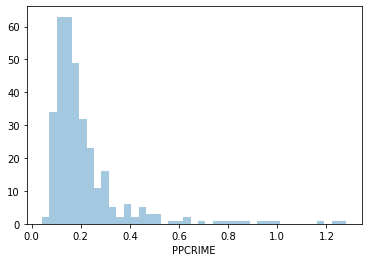

In [10]:
#create Incidence table and add crime per resident column (PPCRIME)
crime_incidence = crime_join[['LSOA11CD', 'BOROUGH', 'INCIDENCE']]
crime_incidence = crime_incidence.groupby(['LSOA11CD']).sum().reset_index()
crime_incidence = pd.merge(crime_incidence, lsoa_res, on= ['LSOA11CD'])
crime_incidence = crime_incidence[['LSOA11CD', 'INCIDENCE', 'RESIDENTS']]
crime_incidence['PPCRIME'] = crime_incidence['INCIDENCE']/crime_incidence['RESIDENTS'] #CRIME SCORE

#view PPCRIME distribution
sns.distplot(crime_incidence['PPCRIME'], kde=False)
plt.show()

PPCRIME has a right-skewed distribution, with the majority of LSOAs showing as having between 0.1 - 0.25 crimes per resident. We want our scale to be evenly tempered between 0 - 10. For this, we will need to transform the data to remove skew:

D:\DSProjects\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (335). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


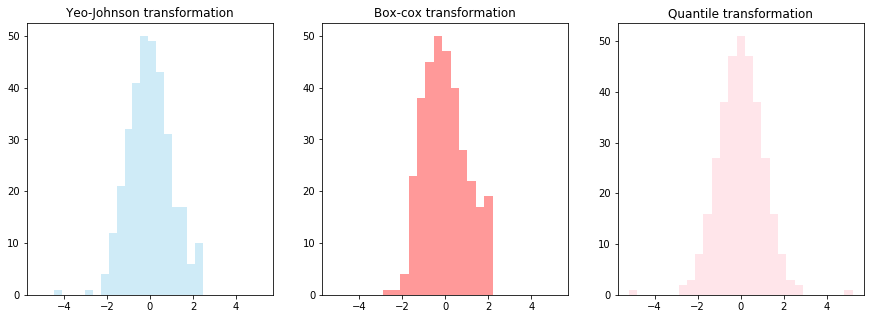

In [11]:
#import transformers
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

#assign transformers to variables
yeo_power_transformer = PowerTransformer(method = 'box-cox')
box_power_transformer = PowerTransformer(method = 'yeo-johnson')
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)

#plot transformation
yeo_power_transformer.fit(crime_incidence[['PPCRIME']])
box_power_transformer.fit(crime_incidence[['PPCRIME']])
quantile_transformer.fit(crime_incidence[['PPCRIME']])


#transform data
crime_rating_ypt = yeo_power_transformer.transform(crime_incidence[['PPCRIME']])
crime_rating_bpt = box_power_transformer.transform(crime_incidence[['PPCRIME']])
crime_rating_qt = quantile_transformer.transform(crime_incidence[['PPCRIME']])

#plot graphs
f, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True)
ypt = sns.distplot(crime_rating_ypt , color="skyblue", label="Sepal Length", ax=axes[0],kde=False)
bpt = sns.distplot(crime_rating_bpt , color="red", label="Sepal Length", ax=axes[1],kde=False)
qt = sns.distplot(crime_rating_qt , color="pink", label="Sepal Length", ax=axes[2],kde=False)
ypt.title.set_text('Yeo-Johnson transformation')
bpt.title.set_text('Box-cox transformation')
qt.title.set_text('Quantile transformation')

We will choose the yeo-johnson transformation as it removes skew and retains weight towards lower scores.

In [12]:
crime_incidence['PPCRIME'] = crime_rating_ypt

Now to choose a scaling method for transformed data.

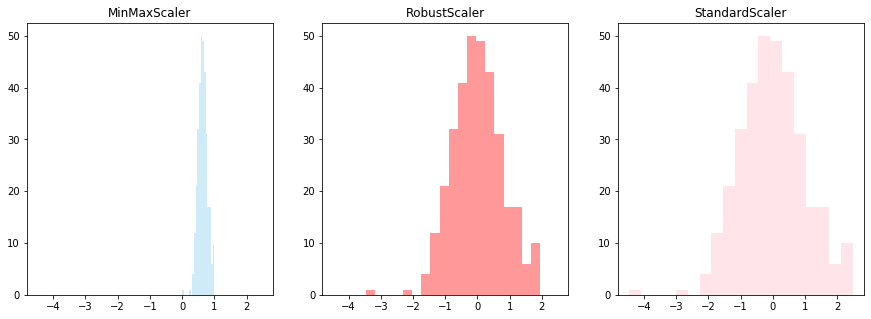

In [13]:
#Evalaute Scaling on PP crime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

#assign scaler variables
mm_scaler = MinMaxScaler()
r_scaler = preprocessing.RobustScaler()
s_scaler = preprocessing.StandardScaler()

#transform data
crime_rating_mm = mm_scaler.fit_transform(crime_incidence.iloc[:,3:4])
crime_rating_r = r_scaler.fit_transform(crime_incidence.iloc[:,3:4])
crime_rating_s = s_scaler.fit_transform(crime_incidence.iloc[:,3:4])

#plot graphs
f, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True)
mm = sns.distplot(crime_rating_mm , color="skyblue", label="Sepal Length", ax=axes[0],kde=False)
r = sns.distplot(crime_rating_r , color="red", label="Sepal Length", ax=axes[1],kde=False)
s = sns.distplot(crime_rating_s , color="pink", label="Sepal Length", ax=axes[2],kde=False)
mm.title.set_text('MinMaxScaler')
r.title.set_text('RobustScaler')
s.title.set_text('StandardScaler')

We want a scale which uses positive integers and a small range, so MinMaxScaler will be used. We will then convert the score range from 0 - 1 to 0 - 10:

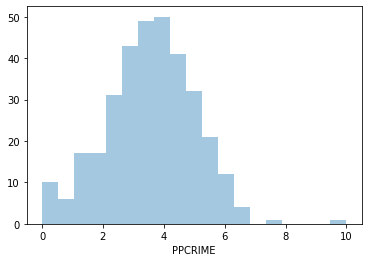

In [14]:
#adding MinMax scaled and transformed crime ratings
crime_incidence['PPCRIME'] = crime_rating_mm

#turn the ppcrime into score out 10 and view the distribution
crime_incidence['PPCRIME'].describe()
crime_incidence['PPCRIME'] = (1-crime_incidence['PPCRIME'])*10
sns.distplot(crime_incidence['PPCRIME'], kde=False)
plt.show()

Let's merge crime scores with borough data:

In [19]:
#merge LSOA and PPCRIME and drop 
crime_geo = pd.merge(lsoa_res, crime_incidence, on=['LSOA11CD'])
crime_geo = crime_geo[['LSOA11CD', 'PPCRIME']]

print("Crime Geo Type: ", type(crime_geo)," | Crime Crime Geo Shape: ", crime_geo.shape)
print("Crime Restaurant Shape: ", type(restaurant)," | Crime Restaurant Shape: ", restaurant.shape)

Crime Geo Type:  <class 'pandas.core.frame.DataFrame'>  | Crime Crime Geo Shape:  (335, 2)
Crime Restaurant Shape:  <class 'pandas.core.frame.DataFrame'>  | Crime Restaurant Shape:  (7, 6)


### 4.3 Visualising Data

#### 4.3.1 Download the JSON file for London LSOAs

In [20]:
#download JSON file
url = 'https://raw.githubusercontent.com/chikaned/IBM-example/master/lsoa.json'
import urllib.request, json 
def getResponse(url):
    operUrl = urllib.request.urlopen(url)
    if(operUrl.getcode()==200):
        data = operUrl.read()
        jsonData = json.loads(data)
    else:
        print("Error receiving data", operUrl.getcode())
    return jsonData
lsoa_geo = getResponse(url)

#### 4.3.2 Creating London Choropleth Maps using GeoJSON data in Folium

In [21]:
#create Choropleth Map
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles=None)
folium.TileLayer('CartoDB positron',name="Stamen Toner",control=False).add_to(map)
map.choropleth(geo_data=lsoa_geo,
               name= 'Choropleth',
               data = crime_geo,
               columns = ['LSOA11CD','PPCRIME'],
               key_on='feature.properties.LSOA11CD',
               smooth_factor = 1,
               fill_color='RdYlGn', fill_opacity=0.3, line_opacity=0.2,
               legend_name='Safety Rating')
    
#iterating over the LAT,LON,NAME and 
for lat, lng, name, rating in zip(restaurant.LAT, restaurant.LNG, restaurant.NAME, restaurant.USERSCORE):
    # marker() takes location coordinates as a list as an argument 
    folium.Marker(location=[lat,lng],popup = (str(name).title() + '<br>'
                 'Rating: ' + str(rating) + '<br>'),
                  icon= folium.Icon(color='black',icon = 'cloud',icon_color = 'white')).add_to(map) 
    
#add home marker
folium.Marker(
    [latitude, longitude],
    popup='You',
    icon=folium.Icon(color='beige',icon='home')
    ).add_to(map)
map

D:\DSProjects\Anaconda\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## 5. Discussion & Conclusion

The project succeeded in depicting crime and restaurant scores within a Folium map. However, there were some shortcomings with the data quality and coding. Firstly, the coverage of the FourSquare restaurant data for Southwark and Lewisham was very limited. FourSquare only had data for seven restaurants in an area dense with bars, takeaways, and restaurants. In future iterations, I would explore using a more popular dataset for restaurant venues and review data, such as Google or Tripadvisor. Such data would allow for meaningful integration of clustering techniques to explore trends among restaurants.

The crime per resident metric (PPCRIME) was an inaccurate representation of crime in certain LSOA areas. For example, the crime score near London Bridge(top left region of LSOAs), was disproportionately high relative to the other regions. This is probably because London Bridge is a busy part of London where a large number of non-residents are victims of crimes. This would distort PPCRIME ratings for the area.

The map itself could be improved too. Adding HTML images of restaurant fronts on the folium marker pop-ups, alongside additional restaurant info, such as cost and opening hours would create a more informative experience for end-users. Moreover, including a coloured rating scale for restaurant pop-ups (much like LSOA crime ratings) would provide an easy visual cue to help users quickly identify top-rated restaurants in low crime per resident areas. Additional functions such as a genre filter (i.e pizza, Chinese, vegan) would allow users to hone their experience.

Overall, this project was a functional success in mapping LSOA crime scores and with restaurant data. However, there is large room for improvement over the quantity of restaurant data integrated into the map and the styling of the map itself.